In [1]:
import os
import torch
from dataset import get_data_transforms, load_data
import numpy as np
from resnet import resnet18, resnet34, resnet50, wide_resnet50_2
from de_resnet import de_resnet18, de_resnet50, de_wide_resnet50_2
from torch.nn import functional as F
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import acl
import numpy as np
import time
from PIL import Image
from dataset import get_data_transforms, load_data
import torch
from obs import ObsClient
from obs import PutObjectHeader
import os
import traceback

ACL_MEM_MALLOC_HUGE_FIRST = 0
ACL_MEMCPY_HOST_TO_DEVICE = 1
ACL_MEMCPY_DEVICE_TO_HOST = 2
class net:

#   def __init__(self, model_path):
        # 初始化函数，需要在后续步骤中实现。
  def __init__(self, model_path):
     # 初始化函数
     self.device_id = 0

     # step1: 初始化
     ret = acl.init()
     # 指定运算的Device
     ret = acl.rt.set_device(self.device_id)

     # step2: 加载模型，本示例为ResNet-50模型
     # 加载离线模型文件，返回标识模型的ID
     self.model_id, ret = acl.mdl.load_from_file(model_path)
     # 创建空白模型描述信息，获取模型描述信息的指针地址
     self.model_desc = acl.mdl.create_desc()
     # 通过模型的ID，将模型的描述信息填充到model_desc
     ret = acl.mdl.get_desc(self.model_desc, self.model_id)

     # step3：创建输入输出数据集
     # 创建输入数据集
     self.input_dataset, self.input_data = self.prepare_dataset('input')
     # 创建输出数据集
     self.output_dataset, self.output_data = self.prepare_dataset('output')



  def prepare_dataset(self, io_type):
     # 准备数据集
     if io_type == "input":
         # 获得模型输入的个数
         io_num = acl.mdl.get_num_inputs(self.model_desc)
         acl_mdl_get_size_by_index = acl.mdl.get_input_size_by_index
     else:
         # 获得模型输出的个数
         io_num = acl.mdl.get_num_outputs(self.model_desc)
         acl_mdl_get_size_by_index = acl.mdl.get_output_size_by_index
     # 创建aclmdlDataset类型的数据，描述模型推理的输入。
     dataset = acl.mdl.create_dataset()
     datas = []
     for i in range(io_num):
         # 获取所需的buffer内存大小
         buffer_size = acl_mdl_get_size_by_index(self.model_desc, i)
         # 申请buffer内存
         buffer, ret = acl.rt.malloc(buffer_size, ACL_MEM_MALLOC_HUGE_FIRST)#location 返回了一个指针地址 和 ret 错误指数
         # 从内存创建buffer数据
         data_buffer = acl.create_data_buffer(buffer, buffer_size)
         # 将buffer数据添加到数据集
         _, ret = acl.mdl.add_dataset_buffer(dataset, data_buffer)
         datas.append({"buffer": buffer, "data": data_buffer, "size": buffer_size})
     return dataset, datas

#   def forward(self, inputs):
        # 执行推理任务，需要在后续步骤中实现。
  def forward(self, inputs):
     # 执行推理任务
     # 遍历所有输入，拷贝到对应的buffer内存中
     input_num = len(inputs)#1
     for i in range(input_num):
         bytes_data = inputs[i].tobytes()
         bytes_ptr = acl.util.bytes_to_ptr(bytes_data)
         # 将图片数据从Host传输到Device。 ####这里就跟预处理的有关了，input从img已经变成了长度为1的东西
         ret = acl.rt.memcpy(self.input_data[i]["buffer"],   # 目标地址 device
                             self.input_data[i]["size"],     # 目标地址大小
                             bytes_ptr,                      # 源地址 host
                             len(bytes_data),                # 源地址大小
                             ACL_MEMCPY_HOST_TO_DEVICE)      # 模式:从host到device
     # 执行模型推理。
     ret = acl.mdl.execute(self.model_id, self.input_dataset, self.output_dataset)
     # 处理模型推理的输出数据，输出top5置信度的类别编号。
     inference_result = []
     # print(f"output_data={self.output_data}")
     for i, item in enumerate(self.output_data):
         buffer_host, ret = acl.rt.malloc_host(self.output_data[i]["size"])
         # 将推理输出数据从Device传输到Host。
         ret = acl.rt.memcpy(buffer_host,                    # 目标地址 host
                             self.output_data[i]["size"],    # 目标地址大小
                             self.output_data[i]["buffer"],  # 源地址 device
                             self.output_data[i]["size"],    # 源地址大小
                             ACL_MEMCPY_DEVICE_TO_HOST)      # 模式：从device到host
         # 从内存地址获取bytes对象
         bytes_out = acl.util.ptr_to_bytes(buffer_host, self.output_data[i]["size"])
         # 按照float32格式将数据转为numpy数组
         data = np.frombuffer(bytes_out, dtype=np.float32)
         inference_result.append(data)
         
     #     #得到的数据结果
     # vals = np.array(inference_result).flatten()
     # # 对结果进行softmax转换
     # vals = np.exp(vals)
     # vals = vals / np.sum(vals)

     return inference_result

#   def __del__(self):
        # 析构函数，按照初始化资源的相反顺序释放资源，需要在后续步骤中实现。
  def __del__(self):
     # 析构函数 按照初始化资源的相反顺序释放资源。
     # 销毁输入输出数据集
     for dataset in [self.input_data, self.output_data]:
         while dataset:
             item = dataset.pop()
             ret = acl.destroy_data_buffer(item["data"])    # 销毁buffer数据
             ret = acl.rt.free(item["buffer"])              # 释放buffer内存
     ret = acl.mdl.destroy_dataset(self.input_dataset)      # 销毁输入数据集
     ret = acl.mdl.destroy_dataset(self.output_dataset)     # 销毁输出数据集
     # 销毁模型描述
     ret = acl.mdl.destroy_desc(self.model_desc)
     # 卸载模型
     ret = acl.mdl.unload(self.model_id)
     # 释放device
     ret = acl.rt.reset_device(self.device_id)
     # acl去初始化
     ret = acl.finalize()
print("1")

1


In [2]:
class net2:

#   def __init__(self, model_path):
        # 初始化函数，需要在后续步骤中实现。
  def __init__(self, model_path):
     # 初始化函数
     self.device_id = 0

     # step1: 初始化
     ret = acl.init()
     
     ret = acl.rt.set_device(self.device_id)

     # step2: 加载模型，本示例为ResNet-50模型
     # 加载离线模型文件，返回标识模型的ID
     self.model_id, ret = acl.mdl.load_from_file(model_path)
     # 创建空白模型描述信息，获取模型描述信息的指针地址
     self.model_desc = acl.mdl.create_desc()
     # 通过模型的ID，将模型的描述信息填充到model_desc
     ret = acl.mdl.get_desc(self.model_desc, self.model_id)

     # step3：创建输入输出数据集
     # 创建输入数据集
     self.input_dataset, self.input_data = self.prepare_dataset('input')
     # 创建输出数据集
     self.output_dataset, self.output_data = self.prepare_dataset('output')



  def prepare_dataset(self, io_type):
     # 准备数据集
     if io_type == "input":
         # 获得模型输入的个数
         io_num = acl.mdl.get_num_inputs(self.model_desc)
         acl_mdl_get_size_by_index = acl.mdl.get_input_size_by_index
     else:
         # 获得模型输出的个数
         io_num = acl.mdl.get_num_outputs(self.model_desc)
         acl_mdl_get_size_by_index = acl.mdl.get_output_size_by_index
     # 创建aclmdlDataset类型的数据，描述模型推理的输入。
     dataset = acl.mdl.create_dataset()
     datas = []
     for i in range(io_num):
         # 获取所需的buffer内存大小
         buffer_size = acl_mdl_get_size_by_index(self.model_desc, i)
         # 申请buffer内存
         buffer, ret = acl.rt.malloc(buffer_size, ACL_MEM_MALLOC_HUGE_FIRST)#location 返回了一个指针地址 和 ret 错误指数
         # 从内存创建buffer数据
         data_buffer = acl.create_data_buffer(buffer, buffer_size)
         # 将buffer数据添加到数据集
         _, ret = acl.mdl.add_dataset_buffer(dataset, data_buffer)
         datas.append({"buffer": buffer, "data": data_buffer, "size": buffer_size})
     return dataset, datas

#   def forward(self, inputs):
        # 执行推理任务，需要在后续步骤中实现。
  def forward(self, inputs):
     # 执行推理任务
     # 遍历所有输入，拷贝到对应的buffer内存中
     input_num = len(inputs)#1
     for i in range(input_num):
         bytes_data = inputs[i].tobytes()
         bytes_ptr = acl.util.bytes_to_ptr(bytes_data)
         # 将图片数据从Host传输到Device。 ####这里就跟预处理的有关了，input从img已经变成了长度为1的东西
         ret = acl.rt.memcpy(self.input_data[i]["buffer"],   # 目标地址 device
                             self.input_data[i]["size"],     # 目标地址大小
                             bytes_ptr,                      # 源地址 host
                             len(bytes_data),                # 源地址大小
                             ACL_MEMCPY_HOST_TO_DEVICE)      # 模式:从host到device
     # 执行模型推理。
     ret = acl.mdl.execute(self.model_id, self.input_dataset, self.output_dataset)
     # 处理模型推理的输出数据，输出top5置信度的类别编号。
     inference_result = []
     # print(f"output_data={self.output_data}")
     for i, item in enumerate(self.output_data):
         buffer_host, ret = acl.rt.malloc_host(self.output_data[i]["size"])
         # 将推理输出数据从Device传输到Host。
         ret = acl.rt.memcpy(buffer_host,                    # 目标地址 host
                             self.output_data[i]["size"],    # 目标地址大小
                             self.output_data[i]["buffer"],  # 源地址 device
                             self.output_data[i]["size"],    # 源地址大小
                             ACL_MEMCPY_DEVICE_TO_HOST)      # 模式：从device到host
         # 从内存地址获取bytes对象
         bytes_out = acl.util.ptr_to_bytes(buffer_host, self.output_data[i]["size"])
         # 按照float32格式将数据转为numpy数组
         data = np.frombuffer(bytes_out, dtype=np.float32)
         inference_result.append(data)
         
     #     #得到的数据结果
     # vals = np.array(inference_result).flatten()
     # # 对结果进行softmax转换
     # vals = np.exp(vals)
     # vals = vals / np.sum(vals)

     return inference_result

#   def __del__(self):
        # 析构函数，按照初始化资源的相反顺序释放资源，需要在后续步骤中实现。
  def __del__(self):
     # 析构函数 按照初始化资源的相反顺序释放资源。
     # 销毁输入输出数据集
     for dataset in [self.input_data, self.output_data]:
         while dataset:
             item = dataset.pop()
             ret = acl.destroy_data_buffer(item["data"])    # 销毁buffer数据
             ret = acl.rt.free(item["buffer"])              # 释放buffer内存
     ret = acl.mdl.destroy_dataset(self.input_dataset)      # 销毁输入数据集
     ret = acl.mdl.destroy_dataset(self.output_dataset)     # 销毁输出数据集
     # 销毁模型描述
     ret = acl.mdl.destroy_desc(self.model_desc)
     # 卸载模型
     ret = acl.mdl.unload(self.model_id)
     # 释放device
     ret = acl.rt.reset_device(self.device_id)
     # acl去初始化
     ret = acl.finalize()

In [3]:
def cal_anomaly_map(fs_list, ft_list, out_size=224, amap_mode='mul'):
    if amap_mode == 'mul':
        anomaly_map = np.ones([out_size, out_size])
    else:
        anomaly_map = np.zeros([out_size, out_size])
    a_map_list = []
    for i in range(len(ft_list)):
        fs = fs_list[i]
        ft = ft_list[i]
        #fs_norm = F.normalize(fs, p=2)
        #ft_norm = F.normalize(ft, p=2)
        a_map = 1 - F.cosine_similarity(fs, ft)
        a_map = torch.unsqueeze(a_map, dim=1)
        a_map = F.interpolate(a_map, size=out_size, mode='bilinear', align_corners=True)
        a_map = a_map[0, 0, :, :].to('cpu').detach().numpy()
        a_map_list.append(a_map)
        if amap_mode == 'mul':
            anomaly_map *= a_map
        else:
            anomaly_map += a_map
    return anomaly_map, a_map_list

def show_cam_on_image(img, anomaly_map):
    #if anomaly_map.shape != img.shape:
        # anomaly_map = cv2.applyColorMap(np.uint8(anomaly_map), cv2.COLORMAP_JET)
    cam = np.float64(anomaly_map)/255 + np.float32(img)/255
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def min_max_norm(image):
    a_min, a_max = image.min(), image.max()
    return (image-a_min)/(a_max - a_min)

def cvt2heatmap(gray):
    heatmap = cv2.applyColorMap(np.uint8(gray), cv2.COLORMAP_JET)
    return heatmap
print("画图模块")

画图模块


In [4]:
data_transform, gt_transform = get_data_transforms(256, 256)

def transfer_pic_img(img_ori):
    # img = Image.open(path).convert("RGB")
    img=Image.fromarray(img_ori).convert("RGB")
    img = data_transform(img)
    img = torch.unsqueeze(img, 0)
    img_tsr=img
    img_arr= np.array(img)
    return img_arr,img_tsr


def classify_anomaly(anomaly_map, threshold=0.2):
    """
    根据阈值对中间部分的异常图进行二分类
    :param anomaly_map: 完整的异常图
    :param threshold: 用于二分类的阈值
    :return: 分类结果 ('Normal' 或 'Anomaly')
    """
    center_anomaly_map = anomaly_map

    # 对裁剪后的中间部分进行平滑处理（可选）
    center_anomaly_map = gaussian_filter(center_anomaly_map, sigma=4)

    # 计算裁剪区域的异常评分，例如使用最大值或均值
    anomaly_score = np.max(center_anomaly_map)

    # 根据阈值进行分类
    if anomaly_score > threshold:
        return 'Anomaly'
    else:
        return 'Normal'

def draw(input, output, img_tsr, classification):
    # 计算异常图
    anomaly_map, _ = cal_anomaly_map([input], [output], img_tsr.shape[-1], amap_mode='a')
    # 对异常图进行平滑处理
    anomaly_map = gaussian_filter(anomaly_map, sigma=4)
    # 归一化并转换为热力图
    anomaly_map = 1 - anomaly_map
    ano_map = min_max_norm(anomaly_map)
    ano_map = cvt2heatmap(ano_map * 255)
    
    # 将图像从 tensor 转换为 numpy 格式
    img = cv2.cvtColor(img_tsr.permute(0, 2, 3, 1).cpu().numpy()[0] * 255, cv2.COLOR_BGR2RGB)
    img = np.uint8(min_max_norm(img) * 255)
    
    # 将异常图叠加到原图上
    ano_map = show_cam_on_image(img, ano_map)
    
    # 在图像上显示分类结果
    plt.imshow(ano_map)
    plt.axis('off')
    plt.title(f"Classification: {classification}")
    plt.show()

    return ano_map  # 返回叠加后的图像


OBS_ACCESS_KEY  = '9GNUENAZSX0UIN5WHJ9R'
OBS_SECRET_KEY  = 'umhOAm01wR65ldrG6tkic1mfMaKD8xaOHbrnkOa3'
OBS_SERVER = "https://obs.cn-north-4.myhuaweicloud.com"

ak = OBS_ACCESS_KEY
sk = OBS_SECRET_KEY
server = OBS_SERVER

obsClient = ObsClient(
    access_key_id=ak,
    secret_access_key=sk,
    server=server
)



def get_obj_num(obs_name):
    try:
        bucketName = obs_name
        # 获取桶的存量信息
        resp = obsClient.getBucketStorageInfo(bucketName)
        # 返回码为2xx时，接口调用成功，否则接口调用失败
        if resp.status < 300:
            print('objectNumber:', resp.body.objectNumber)
            return resp.body.objectNumber
        else:
            print('Get Bucket StorageInfo Failed')
            print('requestId:', resp.requestId)
            print('errorCode:', resp.errorCode)
            print('errorMessage:', resp.errorMessage)
    except:
        print('Get Bucket StorageInfo Failed')
        print(traceback.format_exc())


bucket_name1 = "textile-normal"
image_count1 = get_obj_num(bucket_name1)

bucket_name2 = "textile-anomaly"
image_count2 = get_obj_num(bucket_name2)

bucket_name3 = "textile-anomaly-original"
image_count3 = get_obj_num(bucket_name3)


def upload_image(obs_name, file_name, local_path):
    try:
        # 上传对象的附加头域
        headers = PutObjectHeader()
        bucketName = obs_name
        # 对象名，即上传后的文件名
        objectKey = file_name
        # 待上传文件/文件夹的完整路径
        file_path = local_path
        # 文件上传
        resp = obsClient.putFile(bucketName, objectKey, file_path, headers)
        # 返回码为2xx时，接口调用成功，否则接口调用失败
        if resp.status < 300:
            print('Put File Succeeded')
            print('requestId:', resp.requestId)
            print('etag:', resp.body.etag)
            print('versionId:', resp.body.versionId)
            print('storageClass:', resp.body.storageClass)
        else:
            print('Put File Failed')
            print('requestId:', resp.requestId)
            print('errorCode:', resp.errorCode)
            print('errorMessage:', resp.errorMessage)
    except:
        print('Put File Failed')
        print(traceback.format_exc())

def tran2(outputs):
    output = outputs[-1].reshape([1, 256, 16, 16])
    output = torch.tensor(output)
    return output

def tran1(inputs):
    input = inputs[-1].reshape([1, 256, 16, 16])
    input = torch.tensor(input)
    return input

def save_image(image, path, max_size=(800, 800), quality=85):
    """
    保存图像到指定路径，并可选地压缩图像质量和缩放图像大小。
    
    Args:
        image (numpy array): 图像数据
        path (str): 保存路径
        max_size (tuple): 图像缩放的最大宽高
        quality (int): 图像压缩质量（仅在保存为JPEG时有效）
    """
    # 将图像从 numpy 数组转换为 PIL 图像
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # 缩放图像，使用 LANCZOS 过滤器
    image.thumbnail(max_size, Image.LANCZOS)
    
    # 如果保存路径是 .jpg 或 .jpeg 格式，则压缩质量
    if path.endswith('.jpg') or path.endswith('.jpeg'):
        image.save(path, format='JPEG', quality=quality)
    else:
        image.save(path)  # 如果是 PNG 格式，则不应用质量压缩



def model_draw(img, threshold=0.37):
    global image_count1, image_count2, image_count3
    img_arr, img_tsr = transfer_pic_img(img)
    outputs = resnet18.forward([img_arr])
    inputs = encoder1.forward(img_arr)
    output = tran2(outputs)
    input = tran1(inputs)

    # 获取异常图
    anomaly_map, amap_list = cal_anomaly_map([input], [output], img_tsr.shape[-1], amap_mode='a')

    # 对异常图进行平滑处理
    anomaly_map = gaussian_filter(anomaly_map, sigma=4)

    h, w = anomaly_map.shape
    h_start, h_end = int(h * 0.1), int(h * 1.0)
    w_start, w_end = int(w * 0.1), int(w * 1.0)
    center_anomaly_map = anomaly_map[h_start:h_end, w_start:w_end]

    # 使用阈值进行分类
    classification = classify_anomaly(center_anomaly_map, threshold)
    print(f"Classification result: {classification}")

    # 绘制图像及异常图，并显示分类结果
    anomaly_image = draw(input, output, img_tsr, classification)

    # 保存原图片和异常图到本地 (缩放至最大 800x800 并压缩)
    original_image_path = "./original_image.webp"
    anomaly_image_path = "./anomaly_image.webp"
    save_image(img, original_image_path, max_size=(256, 256), quality=70)
    save_image(anomaly_image, anomaly_image_path, max_size=(256, 256), quality=70)

    # 上传图像到OBS
    if classification == 'Normal':
        bucket_name1 = "textile-normal"
        image_count1+=1
        upload_image(bucket_name1, f"{image_count1}.jpg", original_image_path)
    else:
        bucket_name2 = "textile-anomaly"
        bucket_name3 = "textile-anomaly-original"
        image_count2+=1
        image_count3+=1
        upload_image(bucket_name3, f"{image_count2}.jpg", original_image_path)
        upload_image(bucket_name2, f"{image_count3}.jpg", anomaly_image_path)



objectNumber: 110
objectNumber: 261
objectNumber: 261


Mean value: 125.35841796875
waiting...
Mean value: 123.04876627604166
waiting...
Mean value: 122.95245442708334
waiting...
Mean value: 124.15774088541667
waiting...
Mean value: 123.43430989583334
waiting...
Mean value: 123.605380859375
waiting...
Mean value: 125.15152994791667
waiting...
Mean value: 124.74024739583334
waiting...
Mean value: 124.70249674479167
waiting...
Mean value: 124.33823893229167
waiting...
Mean value: 124.453388671875
waiting...
Mean value: 125.181201171875
waiting...
Mean value: 125.123427734375
waiting...
Mean value: 125.40178385416667
waiting...
Mean value: 125.12819010416666
waiting...
Mean value: 125.06052083333333
waiting...
Mean value: 122.62333984375
waiting...
Mean value: 123.54842447916667
waiting...
Mean value: 124.23462565104167
waiting...
Mean value: 124.74666666666667
waiting...
Mean value: 124.41573567708333
waiting...
Mean value: 120.60239908854167
waiting...
Mean value: 136.43331380208335
waiting...
Mean value: 127.35619140625
waiting...
Mean valu

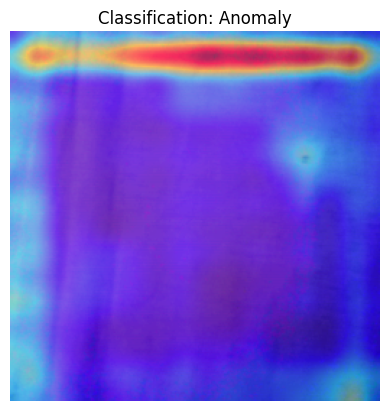

Put File Succeeded
requestId: 000001914F1A328AF08401545EAB3961
etag: "7c8f1883672832dc52aa93b7f1432a5f"
versionId: None
storageClass: None
Put File Succeeded
requestId: 000001914F1A33C9F8EAA067326DC08D
etag: "69c4139538b2b3b31545169e0bf7d196"
versionId: None
storageClass: None
Mean value: 197.48486979166665
Classification result: Anomaly


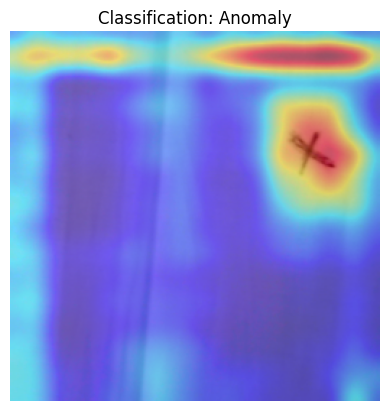

Put File Succeeded
requestId: 000001914F1A39C5F0A519DFBA58713F
etag: "4f57e09f48c58a91e447e99b7b4f16c0"
versionId: None
storageClass: None
Put File Succeeded
requestId: 000001914F1A3CC3EE07170208C0CA35
etag: "1e583fb791c38577343bece8f4bfe078"
versionId: None
storageClass: None
Mean value: 196.747392578125
Classification result: Normal


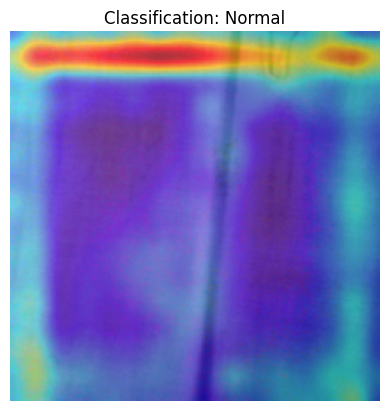

Put File Succeeded
requestId: 000001914F1A42DFF068E472D2553529
etag: "dd1b4bf755b967cbda7c097f7e5359a6"
versionId: None
storageClass: None
Mean value: 196.64825846354168
Classification result: Anomaly


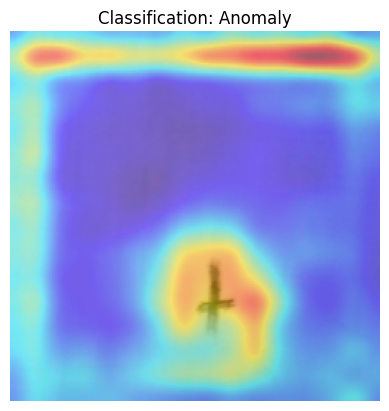

Put File Succeeded
requestId: 000001914F1A4923ED6800D0944F3F96
etag: "e71192483daed75fde85b138a3df2868"
versionId: None
storageClass: None
Put File Succeeded
requestId: 000001914F1A4A3DE0C643C0128CA18F
etag: "337c8d944f914ea41ba9956473c5825d"
versionId: None
storageClass: None
Mean value: 148.48899739583334
waiting...
Mean value: 50.98188151041666
waiting...
Mean value: 103.59313802083334
waiting...
Mean value: 116.95534505208333
waiting...
Mean value: 113.85747395833333
waiting...
Mean value: 119.807802734375
waiting...
Mean value: 217.77016276041667
Classification result: Anomaly


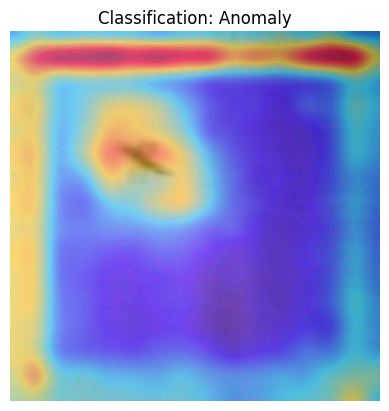

Put File Succeeded
requestId: 000001914F1A7878B9049D07883A7FEE
etag: "9d09d81b85d6d68bfa12a4a2526fabb1"
versionId: None
storageClass: None
Put File Succeeded
requestId: 000001914F1A799EED86F96913CAC5AD
etag: "5016f8a5995cefeeaaea15b494308ca9"
versionId: None
storageClass: None
Mean value: 178.71935221354167
Classification result: Anomaly


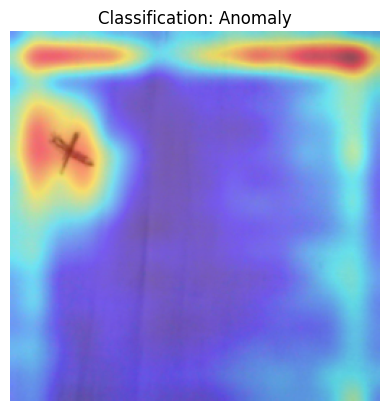

Put File Succeeded
requestId: 000001914F1A7F90E045AB151D50437B
etag: "e78e8971dd1b90a10245f81c70f2580a"
versionId: None
storageClass: None
Put File Succeeded
requestId: 000001914F1A8080E0244A74AF89CD76
etag: "228635d55c112226f77366138591126b"
versionId: None
storageClass: None
Mean value: 167.43430338541665
waiting...
Mean value: 68.47932942708333
waiting...
Mean value: 66.19917317708334
waiting...
Mean value: 112.6271484375
waiting...
Mean value: 113.62914388020833
waiting...
Mean value: 119.60650716145834
waiting...
Mean value: 117.98025716145834
waiting...
Mean value: 121.00207356770834
waiting...
Mean value: 120.753701171875
waiting...
Mean value: 125.84978515625
waiting...
Mean value: 137.827080078125
waiting...
Mean value: 135.44577799479165
waiting...
Mean value: 126.271708984375
waiting...
Mean value: 123.16902669270833
waiting...
Mean value: 122.20469401041667
waiting...
Mean value: 121.636904296875
waiting...
Mean value: 119.55316731770833
waiting...
Mean value: 127.578430989

KeyboardInterrupt: 

In [5]:
import cv2
import numpy as np
import time

def is_center_mean_white(img):
    height, width = img.shape[:2]
    
    # 定义中间部分的边界（例如：图像中间0%的区域）
    center_region = img

    # 转换为灰度图
    gray = cv2.cvtColor(center_region, cv2.COLOR_BGR2GRAY)

    # 计算中间部分的平均像素值
    mean_value = np.mean(gray)
    print("Mean value:", mean_value)

    # 判断平均像素值是否接近白色
    return mean_value > 170  # 根据实际情况调整阈值

if __name__ == "__main__":
    resnet18 = net('../model_18_all/resnet18.om')
    encoder1 = net2('../model_18_encoder/resnet18_encoder.om')

    wait_time = 1  # 初始等待时间为1秒

    while True:
        time.sleep(wait_time)  # 动态调整等待时间
        cap = cv2.VideoCapture(0)
        suc, img = cap.read()  # 捕获当前最新的摄像头画面

        if suc:
            if is_center_mean_white(img):
                model_draw(img)  # 使用最新捕获的画面进行处理
                wait_time = 0.1 # 检测到白色物体，等待5秒
            else:
                print('waiting...')
                wait_time = 1 # 未检测到白色物体，等待1秒
        cap.release()  # 释放摄像头资源

    del resnet18
    del encoder1
